# eICU data exploration

This code does some data exploring on the eICU dataset, focused on the ICU mortality and comparisons with hospital mortality.

Query results can be extracted like so:

```qr = get_query_result(user="dtank", database="eicu", query="SELECT count(*) FROM patient;")```

CSV files of certain data can be extracted like so:

```extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/noteTRY.csv", variablestring="patientUnitStayID, notePath, noteText", table="note")```

In [1]:
import pandas as pd
from pandas import option_context
import numpy as np
import matplotlib.pyplot as plt
# !pip install tableone
from tableone import TableOne, load_dataset
# !pip install icd9cms
from icd9cms.icd9 import search

from dataExtraction import get_query_result, extract_csv, get_df
from datavisualization import xmostcommon_doubleplot, xmostcommon_df

## Patient characteristics

In [112]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/patientCharacteristics.csv",
            variablestring="patient.patientunitstayid, uniquePid, gender, age, ethnicity, admissionHeight, hospitalDischargeStatus, unitType, admissionWeight, unitDischargeStatus, unitvisitnumber,apachepatientresult.actualiculos, apachepatientresult.actualhospitallos, apachepatientresult.apachescore", 
            table="patient, apachepatientresult")  

COPY 297064
data extracted


### Patient characteristics statistics table
We extract and preprocess the data, then use the [tableone](https://pypi.org/project/tableone/) package to make a patient characteristics table for the ICU mortality. 

In [113]:
patientChar = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/patientCharacteristics.csv")
patientChar['age'] = patientChar['age'].replace("> 89", "89") # replace all > 89 with 89 entries 
patientChar['age'] = patientChar['age'].astype('float') # convert age from strings to floats

# renaming conventions
patientChar['gender'] = patientChar['gender'].replace("Other", "Other/Unknown") 
patientChar['gender'] = patientChar['gender'].replace("Unknown", "Other/Unknown") 

patientChar['hospitaldischargestatus'] = patientChar['hospitaldischargestatus'].replace('Alive', 'Alive at hospital discharge')
patientChar['hospitaldischargestatus'] = patientChar['hospitaldischargestatus'].replace('Expired', 'Dead at hospital discharge')

patientChar['unitdischargestatus'] = patientChar['unitdischargestatus'].replace('Alive', 'Alive at ICU discharge')
patientChar['unitdischargestatus'] = patientChar['unitdischargestatus'].replace('Expired', 'Dead at ICU discharge')

# only for unique patients
patientChar = patientChar.drop_duplicates(subset='uniquepid')

# variables for the tableone package
columns = ['gender', 'age', 'ethnicity', 'admissionheight', 'admissionweight', 'unittype', 'actualhospitallos', 'actualiculos', 'apachescore']
categorical = ['gender', 'ethnicity', 'unittype']
labels = {'gender' : 'Gender', 
          'age' : 'Age', 
          'ethnicity' : 'Ethnicity', 
          'admissionheight' : 'Height', 
          'admissionweight' : 'Weight', 
          'unittype' : 'ICU Unit',
          'actualhospitallos' : 'Hospital LoS',
          'actualiculos' : 'ICU LoS',
          'apachescore' : 'Apache score'}

patientCharTableICU = TableOne(patientChar, columns=columns, categorical=categorical, rename=labels, 
                               label_suffix=True, nonnormal=['age'], groupby='unitdischargestatus', pval=True)

In [114]:
# patientCharTableICU
print(patientCharTableICU.tabulate(tablefmt = 'latex')) # print a latex formatted table

\begin{tabular}{lllllll}
\hline
                         &                  & Missing   & Overall          & Alive at ICU discharge   & Dead at ICU discharge   & P-Value   \\
\hline
 n                       &                  &           & 119881           & 112329                   & 7543                    &           \\
 Gender, n (\%)           & Female           & 19        & 54755 (45.7)     & 51319 (45.7)             & 3432 (45.5)             & 0.001     \\
                         & Male             &           & 65077 (54.3)     & 60970 (54.3)             & 4102 (54.4)             &           \\
                         & Other/Unknown    &           & 30 (0.0)         & 23 (0.0)                 & 7 (0.1)                 &           \\
 Age, median [Q1,Q3]     &                  & 15        & 65.0 [53.0,76.0] & 65.0 [52.0,76.0]         & 70.0 [59.0,80.0]        & \ensuremath{<}0.001    \\
 Ethnicity, n (\%)        & African American & 1466      & 13017 (11.0)     & 12230 (11.0

### Patient characteristics: mortality per ethnicity and age plot
We preprocess the patient characteristics data, extract the amount of deaths per ethnicity and age group, divide these by their total ethnicity amount (ethnicity normalized) to get the ethnicity normalized mortality rate per 1000 people. 

In [5]:
patientCharPlot = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/patientCharacteristics.csv")
patientCharPlot = patientCharPlot.drop_duplicates(subset='uniquepid') # only for unique patients

# make age categories
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(0, 20))], '0-20'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(20, 30))], '20-30'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(30, 40))], '30-40'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(40, 50))], '40-50'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(50, 60))], '50-60'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(60, 70))], '60-70'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(70, 80))], '70-80'))
lastcat = [str(x) for x in list(range(80, 90))]
lastcat.append('> 89')
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys(lastcat, '80+'))

# group by ethnicity and age and find the value counts
mortEthAge = patientCharPlot.groupby(['ethnicity', 'age'], as_index=False).unitdischargestatus.value_counts()
mortEthAge = mortEthAge[mortEthAge['unitdischargestatus'] == 'Expired']

# find the total amount per ethnicity category for normalization purposes
AfAmTotal = len(patientChar[patientChar['ethnicity'] == 'African American']['ethnicity'])
AsianTotal = len(patientChar[patientChar['ethnicity'] == 'Asian']['ethnicity'])
CaucasTotal = len(patientChar[patientChar['ethnicity'] == 'Caucasian']['ethnicity'])
NatAmTotal = len(patientChar[patientChar['ethnicity'] == 'Native American']['ethnicity'])
UnknTotal = len(patientChar[patientChar['ethnicity'] == 'Other/Unknown']['ethnicity'])

# find the normalized values for the bar plot
AfAm = (mortEthAge[mortEthAge['ethnicity'] == 'African American']['count']/AfAmTotal*1000).to_list()
Asian = (mortEthAge[mortEthAge['ethnicity'] == 'Asian']['count']/AsianTotal*1000).to_list()
Caucas = (mortEthAge[mortEthAge['ethnicity'] == 'Caucasian']['count']/CaucasTotal*1000).to_list()
NatAm = (mortEthAge[mortEthAge['ethnicity'] == 'Native American']['count']/NatAmTotal*1000).to_list()
Unkn = (mortEthAge[mortEthAge['ethnicity'] == 'Other/Unknown']['count']/UnknTotal*1000).to_list()

Make a plot for all ethnicities and ages, for their normalized icu mortality per 1000 people.

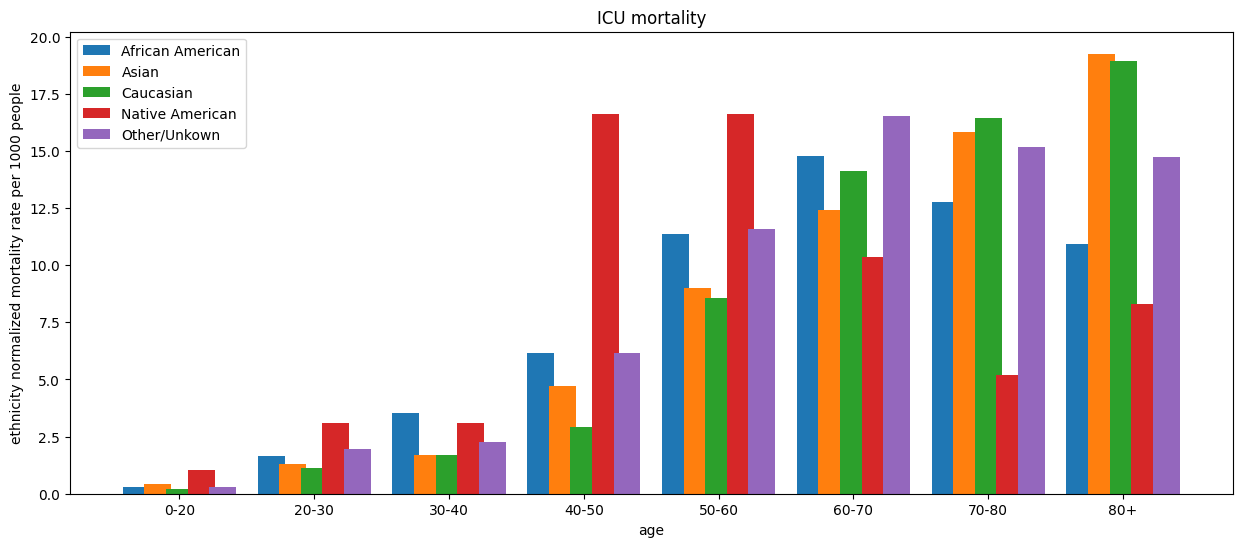

In [6]:
X = np.arange(8)
fig = plt.figure(figsize=(15,6))
margin = 0.8
plt.bar(X + -0.4 * margin, AfAm, width = 0.2)
plt.bar(X + -0.2 * margin, Asian, width = 0.2)
plt.bar(X , Caucas, width = 0.2)
plt.bar(X + 0.2 * margin, NatAm, width = 0.2)
plt.bar(X + 0.4 * margin, Unkn, width = 0.2)
plt.xlabel('age')
plt.ylabel('ethnicity normalized mortality rate per 1000 people')
plt.legend(labels=['African American', 'Asian', 'Caucasian', 'Native American', 'Other/Unkown'])
plt.xticks((0, 1, 2, 3, 4, 5, 6, 7), ('0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+'))
plt.title('ICU mortality')

plt.show()

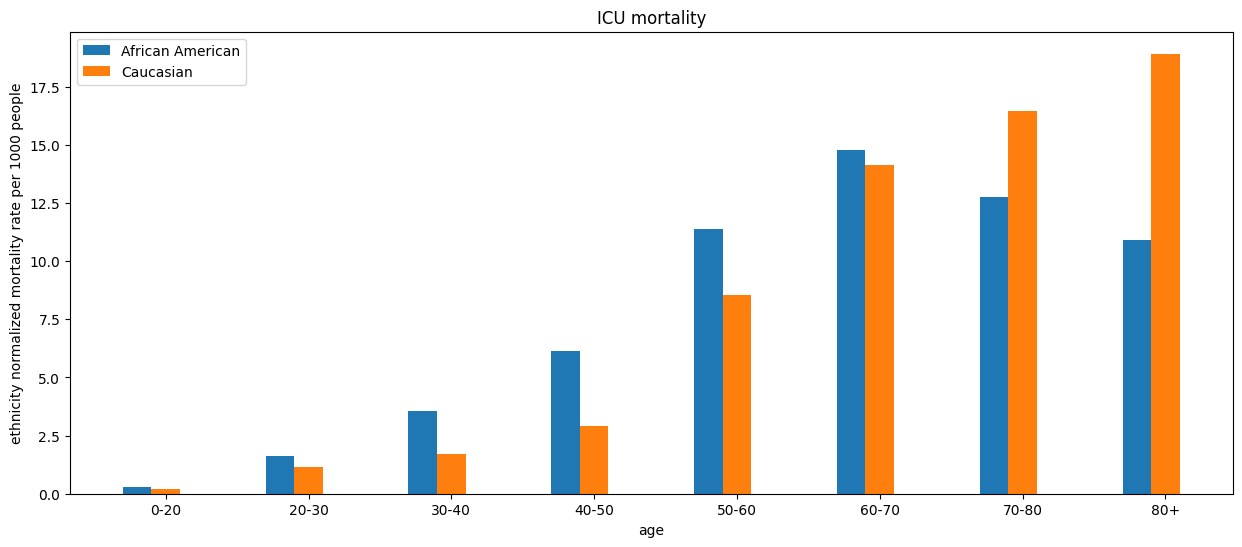

In [7]:
X = np.arange(8)
fig = plt.figure(figsize=(15,6))
margin = 0.8
plt.bar(X + -0.2, AfAm, width = 0.2)
plt.bar(X , Caucas, width = 0.2)
plt.xlabel('age')
plt.ylabel('ethnicity normalized mortality rate per 1000 people')
plt.legend(labels=['African American', 'Caucasian'])
plt.xticks((0, 1, 2, 3, 4, 5, 6, 7), ('0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+'))
plt.title('ICU mortality')

plt.show()

## Patient characteristics: ICU visits

In [8]:
print('Maximum amount of ICU visits: ', patientChar['unitvisitnumber'].max())
print('Average amount of ICU visits: ', patientChar['unitvisitnumber'].mean())

Maximum amount of ICU visits:  15
Average amount of ICU visits:  1.1534653110133677


In [9]:
# get the final amount of ICU visits per patient
uniqueICUvisnum = patientChar.sort_values('unitvisitnumber', ascending=False).drop_duplicates(['uniquepid'])
uniqueICUvisnum = uniqueICUvisnum.unitvisitnumber.value_counts().rename_axis('ICUvisit_amount').reset_index(name='counts')

counts3plus = uniqueICUvisnum[2:]['counts'].sum() # sum the counts from 3+ visits
uniqueICUvisnum = uniqueICUvisnum.iloc[:2] # shorten the dataframe to 2 rows
uniqueICUvisnum.loc[len(uniqueICUvisnum.index)] = [3, counts3plus] # add the last row for 3+ visits

numuniquepats = len(np.unique(patientChar['uniquepid'])) # find the number of unique patients
uniqueICUvisnum['percentage'] = uniqueICUvisnum['counts']/numuniquepats * 100 

uniqueICUvisnum['percentage'] = uniqueICUvisnum['percentage'].round().astype('int') # round the percentages
uniqueICUvisnum['ICUvisit_amount'] = uniqueICUvisnum['ICUvisit_amount'].astype('int') # turn the visit amounts to int

PatientCharPatVis = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/patientCharacteristics.csv")
numuniquepats = len(np.unique(PatientCharPatVis['uniquepid'])) # find the number of unique patients
visitAmount = PatientCharPatVis.uniquepid.value_counts() # find the amount of visists per unique patient
visitAmount = visitAmount.value_counts().rename_axis('visit_amount').reset_index(name='counts') # find the occurence of every visit amount
visitAmount['percentage'] = visitAmount['counts']/numuniquepats * 100 # turn that into a percentage
percentage5 = visitAmount[2:]['percentage'].sum() # sum the percentage from 5+ visits
counts5 = visitAmount[2:]['counts'].sum() # sum the counts from 5+ visits
visitAmount = visitAmount.iloc[:2] # shorten the dataframe to 4 rows
visitAmount.loc[len(visitAmount.index)] = [5, counts5, percentage5] # add the last row for 5+ visits
visitAmount['percentage'] = visitAmount['percentage'].round().astype('int') # round the percentages
visitAmount['visit_amount'] = visitAmount['visit_amount'].astype('int') # turn the visit amounts to int

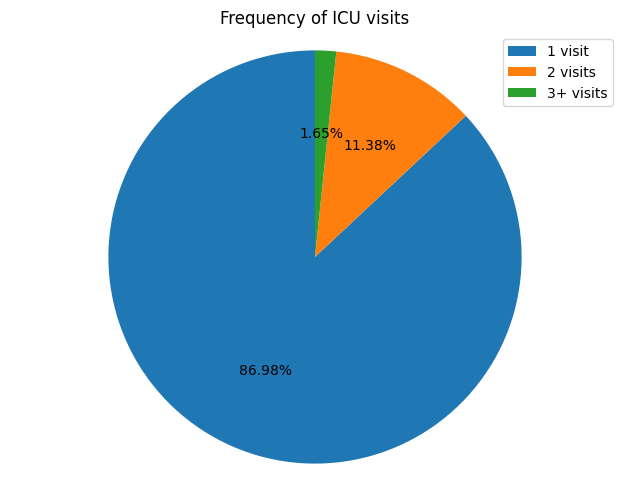

In [10]:
labels= ['1 visit', '2 visits', '3+ visits']
sizes= uniqueICUvisnum['counts']
plt.pie(sizes, startangle=90, autopct='%1.2f%%')
plt.axis('equal')
plt.legend(labels)
plt.tight_layout()
plt.title('Frequency of ICU visits')

plt.show()

Hospital vs ICU

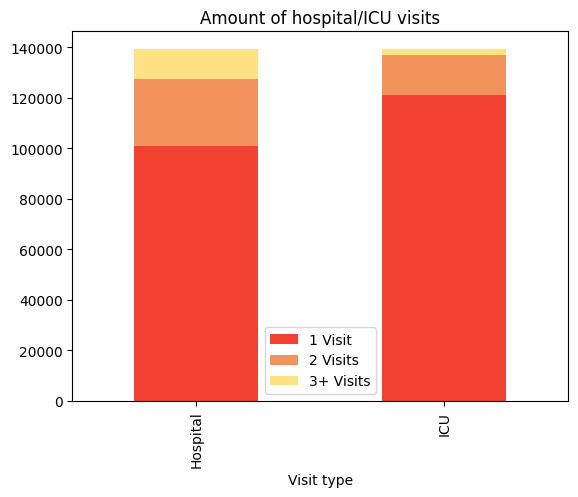

In [118]:
data_frame = pd.DataFrame([['Hospital', visitAmount['counts'][0], visitAmount['counts'][1], visitAmount['counts'][2]], ['ICU', uniqueICUvisnum['counts'][0], uniqueICUvisnum['counts'][1], uniqueICUvisnum['counts'][2]]],
                  columns=['Visit type', '1 Visit', '2 Visits', '3+ Visits'])
data_frame.plot(x='Visit type', kind='bar', stacked=True, title='Amount of hospital/ICU visits', color=['#F24130', '#F2935C', '#FFE283'])
plt.show()

### Patient characteristics: LOS (ICU vs Hospital)

In [12]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/LoS.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, apachepatientresult.actualiculos, apachepatientresult.actualhospitallos", table="patient, apachepatientresult")

COPY 297064
data extracted


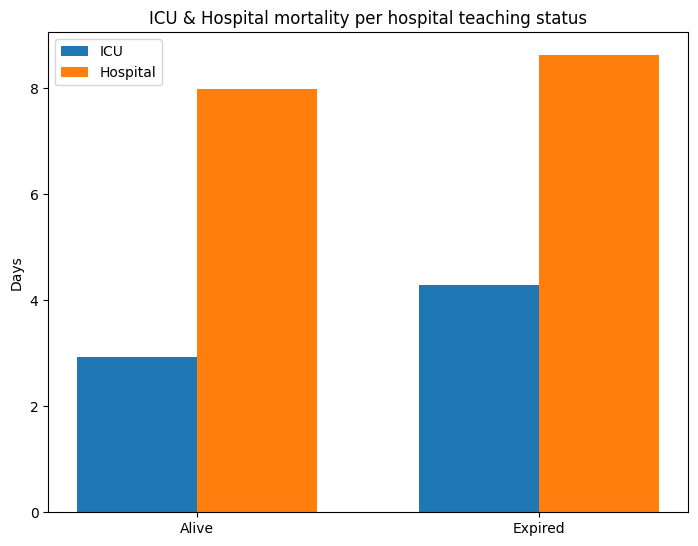

In [13]:
los = pd.read_csv('/home/dtank/data/volume_2/eicu_csv/LoS.csv')
loshos = los.groupby('hospitaldischargestatus')['actualhospitallos'].mean().tolist()
losicu = los.groupby('unitdischargestatus')['actualiculos'].mean().tolist()

# make the plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Alive', 'Expired']
x = np.arange(len(labels))
ax.bar(x - 0.35/2, losicu, 0.35, label='ICU')
ax.bar(x + 0.35/2, loshos, 0.35, label='Hospital')
ax.set_ylabel('Days')
ax.set_xticks(x, labels)
ax.legend()
plt.title('ICU & Hospital mortality per hospital teaching status')
plt.show()

## (Admission) Diagnoses

In [14]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/diagnoses.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.apacheAdmissionDx, patient.hospitalDischargeStatus, patient.unitDischargeStatus, diagnosis.diagnosisString, diagnosis.ICD9Code", table="patient, diagnosis")

COPY 2710672
data extracted


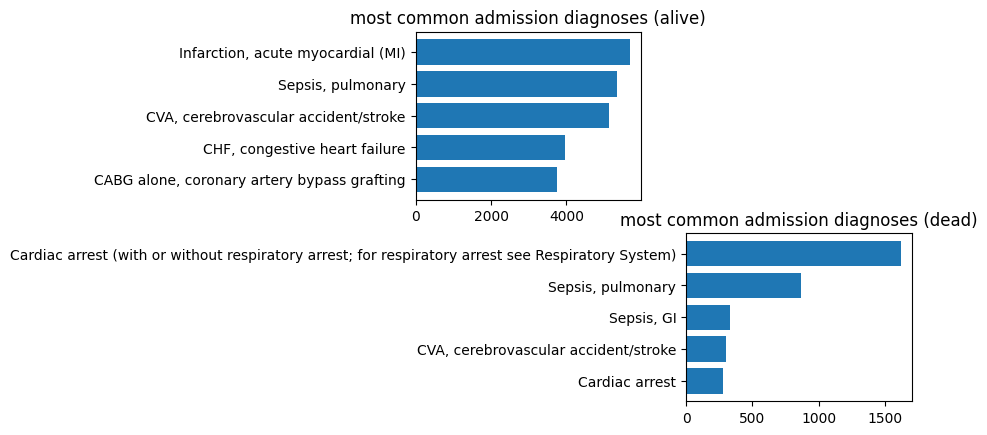

In [85]:
diagnoses = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/diagnoses.csv")
diagnoses = diagnoses.drop_duplicates(subset='uniquepid') # get unique patients
diagnoses['icd9code'] = diagnoses['icd9code'].str.split(',').str[0] # get only the first icd9 code

# most common admission diagnoses
admdiag = diagnoses.groupby('unitdischargestatus', as_index=False)['apacheadmissiondx'].value_counts().reset_index(drop=True)
admdiag_alive = admdiag[admdiag['unitdischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
admdiag_dead = admdiag[admdiag['unitdischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

# plot most common admission diagnoses
xmostcommon_doubleplot(admdiag_alive, admdiag_dead, 'apacheadmissiondx', "most common admission diagnoses")

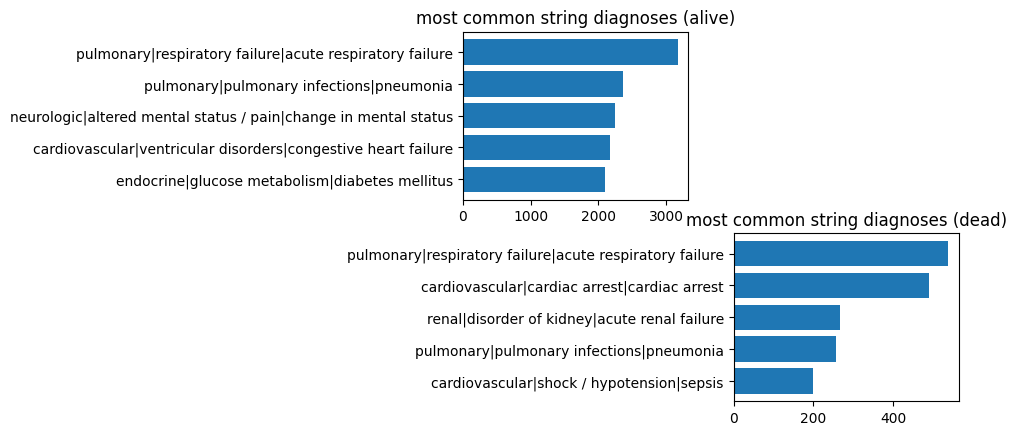

In [16]:
# most common diagnosis strings
diagstring = diagnoses.groupby('unitdischargestatus', as_index=False)['diagnosisstring'].value_counts().reset_index(drop=True)
diagstring_alive = diagstring[diagstring['unitdischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
diagstring_dead = diagstring[diagstring['unitdischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

# plot the most common diagnosis strings
xmostcommon_doubleplot(diagstring_alive, diagstring_dead, 'diagnosisstring', "most common string diagnoses")

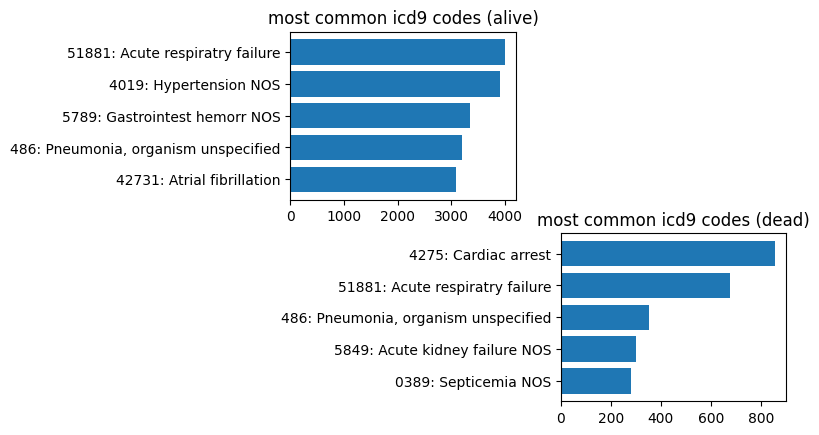

In [88]:
# helper function to convert icd9 code to string
def code_to_string(x):
    try: 
        codeandtext = str(search(x)).split(":")[0:2]
        return codeandtext[0] + ": " + codeandtext[1]
    except:
        return 'None'

# most common icd9 code diagnosis
icd9code = diagnoses.groupby('unitdischargestatus', as_index=False)['icd9code'].value_counts().reset_index(drop=True)
icd9code_alive = icd9code[icd9code['unitdischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
icd9code_dead = icd9code[icd9code['unitdischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)
c['icd9codetostring'] = icd9code['icd9code'].apply(code_to_string)
icd9code_dead['icd9codetostring'] = icd9code['icd9code'].apply(code_to_string)

xmostcommon_doubleplot(icd9code_alive, icd9code_dead, 'icd9codetostring', "most common icd9 codes")

## Hospital information: ICU vs Hospital

In [18]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/hospital.csv", variablestring="patient.hospitalID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, hospital.teachingstatus, hospital.region", table="patient, hospital", joinon='hospitalID')

COPY 200859
data extracted


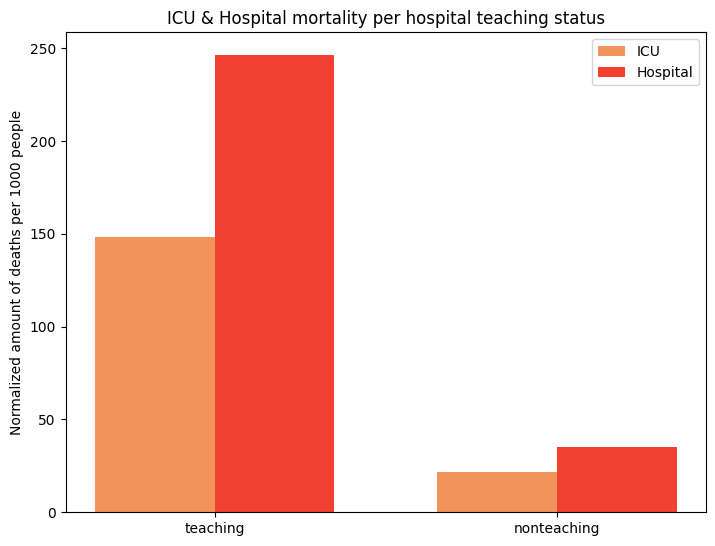

In [110]:
hospital = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/hospital.csv")

# ICU
# find the amount of dead patients per hospital status
hospital_teachingstatus = hospital.groupby(['teachingstatus'], as_index=False).unitdischargestatus.value_counts()
hospital_teachingstatus = hospital_teachingstatus[hospital_teachingstatus['unitdischargestatus']=='Expired']

# find the total amount of patients per hospital status
total_nonteaching = (hospital['teachingstatus']=='f').sum()
total_teaching = (hospital['teachingstatus']=='t').sum()

# calculate the mortality per 1000 people per hospital status
mortality_teaching_icu = hospital_teachingstatus['count'][1]/total_teaching*1000
mortality_nonteaching_icu = hospital_teachingstatus['count'][3]/total_nonteaching*1000

# HOSPITAL
# find the amount of dead patients per hospital status
hospital_teachingstatus = hospital.groupby(['teachingstatus'], as_index=False).hospitaldischargestatus.value_counts()
hospital_teachingstatus = hospital_teachingstatus[hospital_teachingstatus['hospitaldischargestatus']=='Expired']

# find the total amount of patients per hospital status
total_nonteaching = (hospital['teachingstatus']=='f').sum()
total_teaching = (hospital['teachingstatus']=='t').sum()

# calculate the mortality per 1000 people per hospital status
mortality_teaching_hos = hospital_teachingstatus['count'][1]/total_teaching*1000
mortality_nonteaching_hos = hospital_teachingstatus['count'][3]/total_nonteaching*1000


# make the plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['teaching', 'nonteaching']
x = np.arange(len(labels))
norm_mort_icu = [mortality_teaching_icu, mortality_nonteaching_icu]
norm_mort_hos = [mortality_teaching_hos, mortality_nonteaching_hos]
ax.bar(x - 0.35/2, norm_mort_icu, 0.35, label='ICU', color='#F2935C')
ax.bar(x + 0.35/2, norm_mort_hos, 0.35, label='Hospital', color='#F24130')
ax.set_ylabel('Normalized amount of deaths per 1000 people')
ax.set_xticks(x, labels)
ax.legend()
plt.title('ICU & Hospital mortality per hospital teaching status')
plt.show()

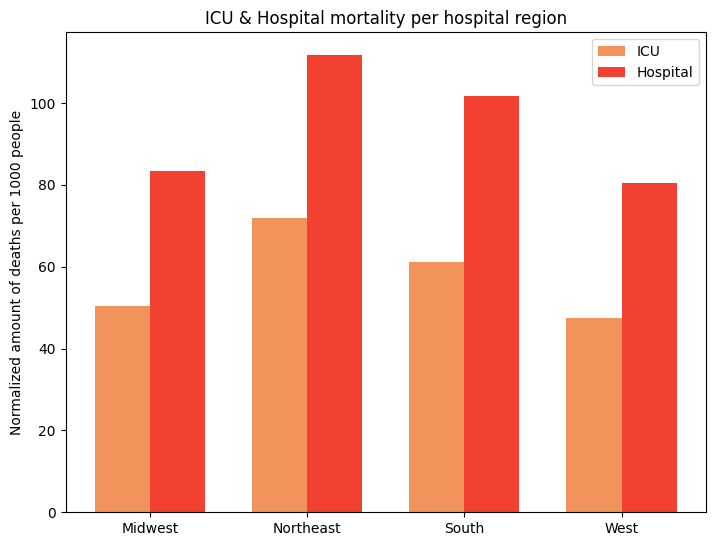

In [111]:
# ICU
# gather data filtered on hospital region and amount of deaths
hospital_region = hospital.groupby(['region'], as_index=False).unitdischargestatus.value_counts()
hospital_region = hospital_region[hospital_region['unitdischargestatus']=='Expired']

# find total of patients per region
total_midwest = (hospital['region']=='Midwest').sum()
total_northeast = (hospital['region']=='Northeast').sum()
total_south = (hospital['region']=='South').sum()
total_west = (hospital['region']=='West').sum()

# calculate the normalized amount of deaths per region
mortality_midwest_icu = hospital_region['count'][1]/total_midwest*1000
mortality_northeast_icu = hospital_region['count'][3]/total_northeast*1000
mortality_south_icu = hospital_region['count'][5]/total_south*1000
mortality_west_icu = hospital_region['count'][7]/total_west*1000

# HOSPITAL
# gather data filtered on hospital region and amount of deaths
hospital_region = hospital.groupby(['region'], as_index=False).hospitaldischargestatus.value_counts()
hospital_region = hospital_region[hospital_region['hospitaldischargestatus']=='Expired']

# find total of patients per region
total_midwest = (hospital['region']=='Midwest').sum()
total_northeast = (hospital['region']=='Northeast').sum()
total_south = (hospital['region']=='South').sum()
total_west = (hospital['region']=='West').sum()

# calculate the normalized amount of deaths per region
mortality_midwest_hos = hospital_region['count'][1]/total_midwest*1000
mortality_northeast_hos = hospital_region['count'][3]/total_northeast*1000
mortality_south_hos = hospital_region['count'][5]/total_south*1000
mortality_west_hos = hospital_region['count'][7]/total_west*1000

# make the plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = hospital_region['region']
x = np.arange(len(labels))
norm_mort_icu = [mortality_midwest_icu, mortality_northeast_icu, mortality_south_icu, mortality_west_icu]
norm_mort_hos = [mortality_midwest_hos, mortality_northeast_hos, mortality_south_hos, mortality_west_hos]
ax.bar(x - 0.35/2, norm_mort_icu, 0.35, label='ICU', color='#F2935C')
ax.bar(x + 0.35/2, norm_mort_hos, 0.35, label='Hospital', color='#F24130')
ax.set_ylabel('Normalized amount of deaths per 1000 people')
ax.set_xticks(x, labels)
ax.legend()
plt.title("ICU & Hospital mortality per hospital region")
plt.show()

## Past History

In [21]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/pastHistory.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, pastHistory.pasthistoryvaluetext", table="patient, pasthistory")

COPY 1149180
data extracted


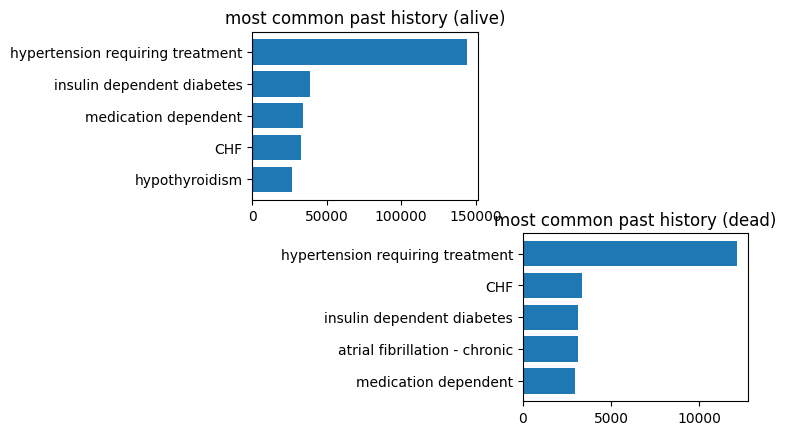

In [95]:
pastHistory = pd.read_csv('/home/dtank/data/volume_2/eicu_csv/pastHistory.csv')
pastHistory = pastHistory[pastHistory.pasthistoryvaluetext != 'Performed'] # remove the 'performed' value rows since it does not give insightful information

# find the most common past history for alive and expired patients
pasthist = pastHistory.groupby('unitdischargestatus', as_index=False)['pasthistoryvaluetext'].value_counts().reset_index(drop=True)
pasthist_alive = pasthist[pasthist['unitdischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
pasthist_dead = pasthist[pasthist['unitdischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

# make the plot
xmostcommon_doubleplot(pasthist_alive, pasthist_dead, 'pasthistoryvaluetext', 'most common past history')

## Treatment

In [23]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/treatment.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, treatment.treatmentstring", table="patient, treatment")

COPY 3688745
data extracted


In [24]:
treatment = pd.read_csv('/home/dtank/data/volume_2/eicu_csv/treatment.csv')
treatment['treatmentvalue'] = treatment['treatmentstring'].str.split('|').str[-1] # take only the treatment value (last one in treatment path)

# show the top 20 treatment amounts per patient
treatmentAmount = treatment.uniquepid.value_counts()
treatmentAmount = treatmentAmount.value_counts().rename_axis('treatment_amount').reset_index(name='counts')
treatmentAmount[:20]

,treatment_amount,counts
0,1,13830
1,2,11791
2,3,9475
3,4,7993
4,5,6347
5,6,5472
6,7,4475
7,8,4003
8,9,3319
9,10,3012


In [116]:
print('maximum treatment amounts:', treatmentAmount['treatment_amount'].max())
print('average treatment amounts:', treatmentAmount['treatment_amount'].mean())

maximum treatment amounts: 8123
average treatment amounts: 718.2785782901057


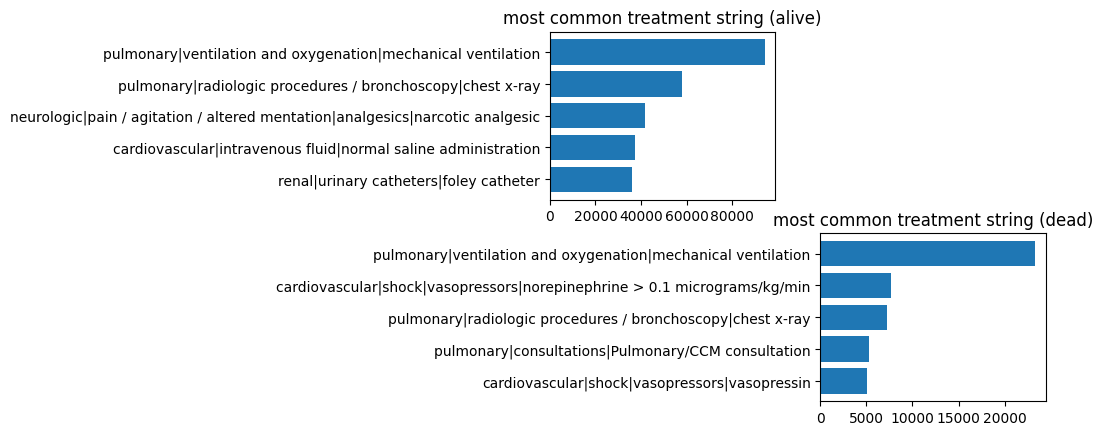

In [26]:
treatmentstring = treatment.groupby('unitdischargestatus', as_index=False)['treatmentstring'].value_counts().reset_index(drop=True)
treatmentstring_alive = treatmentstring[treatmentstring['unitdischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
treatmentstring_dead = treatmentstring[treatmentstring['unitdischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

# make the plot
xmostcommon_doubleplot(treatmentstring_alive, treatmentstring_dead, 'treatmentstring', 'most common treatment string')

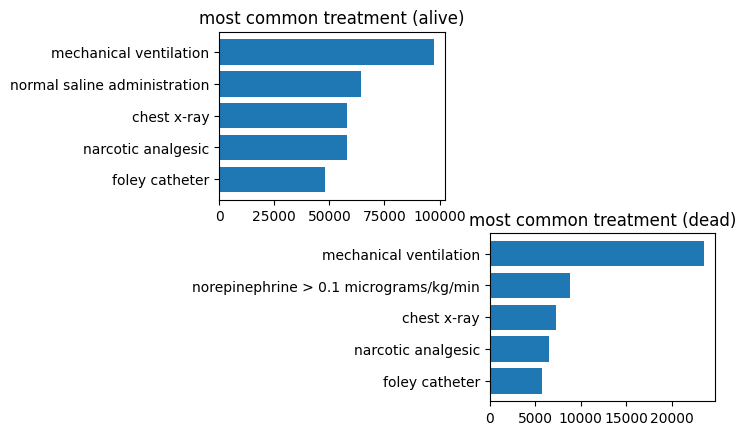

In [99]:
treatmentvalue = treatment.groupby('unitdischargestatus', as_index=False)['treatmentvalue'].value_counts().reset_index(drop=True)
treatmentvalue_alive = treatmentvalue[treatmentvalue['unitdischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
treatmentvalue_dead = treatmentvalue[treatmentvalue['unitdischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

xmostcommon_doubleplot(treatmentvalue_alive, treatmentvalue_dead, 'treatmentvalue', 'most common treatment')

## Predicted and actual mortality

In [28]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/apachepatientresult.csv", variablestring="apachescore, predictedicumortality, actualicumortality, predictedhospitalmortality, actualhospitalmortality", table="apachepatientresult")

COPY 297064
data extracted


In [29]:
apachepatientresult = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/apachepatientresult.csv")
icumortality_apache = apachepatientresult.groupby('actualicumortality')['apachescore'].mean()
icumortality_mortality = apachepatientresult.groupby('actualicumortality')['predictedicumortality'].mean()

print(icumortality_apache)
print()
print(icumortality_mortality)

actualicumortality
ALIVE      52.423158
EXPIRED    93.339060
Name: apachescore, dtype: float64

actualicumortality
ALIVE      0.029384
EXPIRED    0.304714
Name: predictedicumortality, dtype: float64


### Hospital vs ICU

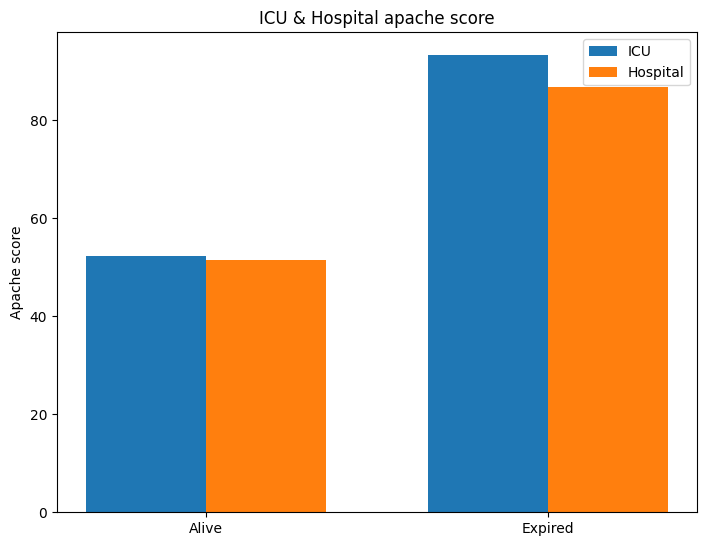

In [30]:
# hospital data
apachepatientresult = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/apachepatientresult.csv")
hospitalmortality_apache = apachepatientresult.groupby('actualhospitalmortality')['apachescore'].mean()
hospitalmortality_mortality = apachepatientresult.groupby('actualhospitalmortality')['predictedhospitalmortality'].mean()

# make the plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Alive', 'Expired']
x = np.arange(len(labels))
apache_icu = [icumortality_apache[0], icumortality_apache[1]]
apache_hos = [hospitalmortality_apache[0], hospitalmortality_apache[1]]
ax.bar(x - 0.35/2, apache_icu, 0.35, label='ICU')
ax.bar(x + 0.35/2, apache_hos, 0.35, label='Hospital')
ax.set_ylabel('Apache score')
ax.set_xticks(x, labels)
ax.legend()
plt.title("ICU & Hospital apache score")
plt.show()

## Admission drugs

In [31]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/admissiondrugs.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, admissionDrug.drugname, admissionDrug.drughiclseqno", table="patient, admissiondrug")

COPY 874920
data extracted


In [32]:
admissiondrug = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/admissiondrugs.csv")
admissiondrug['codeanddrug'] = admissiondrug['drughiclseqno'].astype('string') + ': ' + admissiondrug['drugname'] # show both drug code and drug name in the same column

In [33]:
print('avg amount of admission drugs registered:', admissiondrug['uniquepid'].value_counts().mean())
print('maximum amount of admission drugs registered: ', admissiondrug['uniquepid'].value_counts().max())
print('minimum amount of admission drugs registered: ', admissiondrug['uniquepid'].value_counts().min())

avg amount of admission drugs registered: 27.584336969544108
maximum amount of admission drugs registered:  11671
minimum amount of admission drugs registered:  1


In [34]:
# find the most common drugs given to expired patients
xmostcommon_df(admissiondrug, 'unitdischargestatus', 'codeanddrug', 10)

,codeanddrug,count
4690,6494: AMLODIPINE BESILATE,906
4689,2879: PREDNISONE,933
4687,2074: ALBUTEROL,960
4688,8831: GABAPENTIN,960
4686,2849: LEVOTHYROXINE SODIUM,1169
4685,1794: ASPIRIN,1170
4684,4673: OMEPRAZOLE,1335
4683,1820: ASPIRIN,1399
4682,132: LISINOPRIL,1547
4681,3660: LASIX,1844


## Active medication

In [35]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/medication.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, medication.drugname, medication.drughiclseqno", table="patient, medication")

COPY 7301853
data extracted


In [36]:
medication = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/medication.csv")

# # show both drug code and drug name in the same column and skip nans
medication['codeandmed'] = medication['drughiclseqno'].astype('string') + ': ' + medication['drugname']
medication = medication.dropna()

In [37]:
print('avg amount of active medication per patient:', medication['uniquepid'].value_counts().mean())
print('maximum amount of active medication per patient: ', medication['uniquepid'].value_counts().max())
print('minimum amount of active medication per patient: ', medication['uniquepid'].value_counts().min())

avg amount of active medication per patient: 38.739252260909396
maximum amount of active medication per patient:  1153
minimum amount of active medication per patient:  1


In [38]:
# find the most common drugs given to expired patients
xmostcommon_df(medication, 'unitdischargestatus', 'codeandmed', 10)

,codeandmed,count
1776,4842.0: propofol,1582
1775,926.0: DEXTROSE 50%-WATER,1599
1774,8255.0: SODIUM CHLORIDE 0.9 % IV : 1000 ML,1684
1773,8255.0: NaCl 0.9% MBP,1797
1772,1866.0: ACETAMINOPHEN,1932
1771,3660.0: FUROSEMIDE,2015
1770,1619.0: MIDAZOLAM,2093
1769,25386.0: fentaNYL citrate (PF),2113
1768,8255.0: SODIUM CHLORIDE 0.9%,2614
1767,8255.0: 1000 ML FLEX CONT : SODIUM CHLORIDE 0.9 % IV SOLN,2858


## Lab tests

In [39]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/lab.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, lab.labname", table="patient, lab")

COPY 39132531
data extracted


In [40]:
lab = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/lab.csv")

In [41]:
print('avg amount of ordered lab tests per patient:', lab['uniquepid'].value_counts().mean())
print('maximum amount of ordered lab tests per patient: ', lab['uniquepid'].value_counts().max())
print('minimum amount of ordered lab tests per patient: ', lab['uniquepid'].value_counts().min())

avg amount of ordered lab tests per patient: 283.0583295358375
maximum amount of ordered lab tests per patient:  11933
minimum amount of ordered lab tests per patient:  1


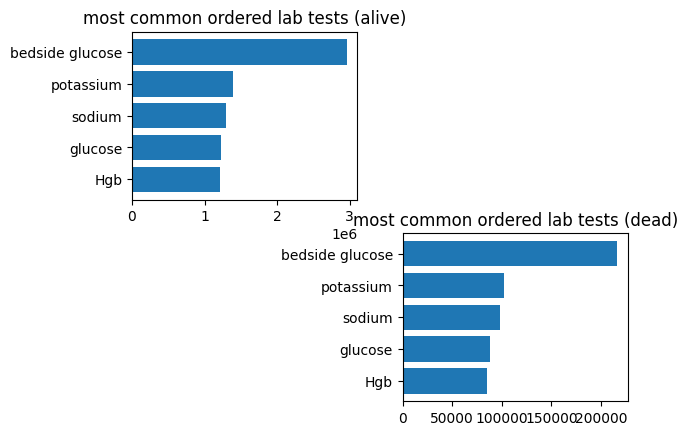

In [105]:
labtest = lab.groupby('unitdischargestatus', as_index=False)['labname'].value_counts().reset_index(drop=True)
labtest_alive = labtest[labtest['unitdischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
labtest_dead = labtest[labtest['unitdischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

xmostcommon_doubleplot(labtest_alive, labtest_dead, 'labname', 'most common ordered lab tests')

## Notes

In [43]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/basicnotes.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, note.notepath, note.notetext", table="patient, note")

COPY 2254179
data extracted


In [44]:
basicnotes = pd.read_csv('/home/dtank/data/volume_2/eicu_csv/basicnotes.csv')

In [53]:
print(len(basicnotes))
print('avg amount of notes per patient:', basicnotes['uniquepid'].value_counts().mean())
print('maximum amount of notes per patient: ', basicnotes['uniquepid'].value_counts().max())
print('minimum amount of notes per patient: ', basicnotes['uniquepid'].value_counts().min())

2254179
avg amount of notes per patient: 16.43239125522128
maximum amount of notes per patient:  2698
minimum amount of notes per patient:  1


In [46]:
print('average amount of notes for dead patients: ', basicnotes.groupby('unitdischargestatus')['uniquepid'].value_counts()['Expired'].mean())
print('average amount of notes for alive patients: ', basicnotes.groupby('unitdischargestatus')['uniquepid'].value_counts()['Alive'].mean())

average amount of notes for dead patients:  19.97348261638185
average amount of notes for alive patients:  15.810856239639154


Hospital VS ICU

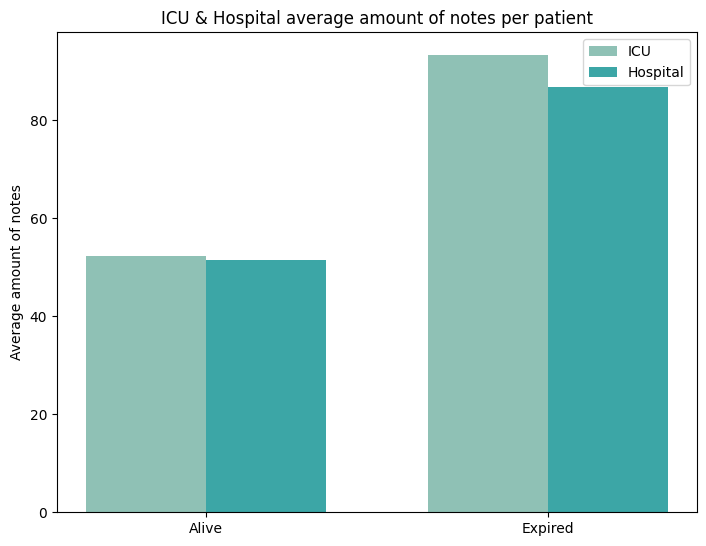

In [51]:
# make the plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Alive', 'Expired']
x = np.arange(len(labels))
avgnotes_icu = basicnotes.groupby('unitdischargestatus')['uniquepid'].value_counts().tolist()
avgnotes_hos = basicnotes.groupby('hospitaldischargestatus')['uniquepid'].value_counts().tolist()
ax.bar(x - 0.35/2, apache_icu, 0.35, label='ICU', color='#8FC1B5')
ax.bar(x + 0.35/2, apache_hos, 0.35, label='Hospital', color='#3CA6A6')
ax.set_ylabel('Average amount of notes')
ax.set_xticks(x, labels)
ax.legend()
plt.title("ICU & Hospital average amount of notes per patient")
plt.show()

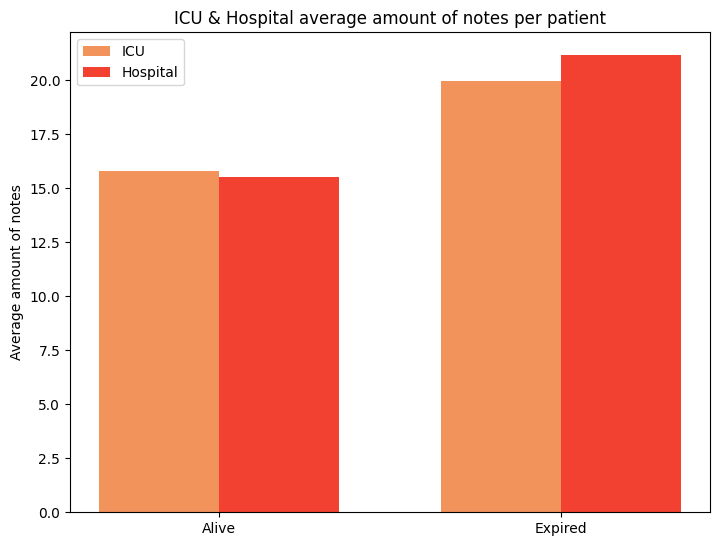

In [62]:
# make the plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Alive', 'Expired']
x = np.arange(len(labels))
avgnotes_icu = [basicnotes.groupby('unitdischargestatus')['uniquepid'].value_counts()['Alive'].mean(), basicnotes.groupby('unitdischargestatus')['uniquepid'].value_counts()['Expired'].mean()]
avgnotes_hos = [basicnotes.groupby('hospitaldischargestatus')['uniquepid'].value_counts()['Alive'].mean(), basicnotes.groupby('hospitaldischargestatus')['uniquepid'].value_counts()['Expired'].mean()]
ax.bar(x - 0.35/2, avgnotes_icu, 0.35, label='ICU', color='#F2935C')
ax.bar(x + 0.35/2, avgnotes_hos, 0.35, label='Hospital', color='#F24130')
ax.set_ylabel('Average amount of notes')
ax.set_xticks(x, labels)
ax.legend()
plt.title("ICU & Hospital average amount of notes per patient")
plt.show()

[15.810856239639154, 19.97348261638185]